In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from datetime import datetime, time

# Data source: CDC Website

### https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html#investigation


In [127]:
#US population. We need it for later
N_US = 327.2*np.power(10,6)
covid19_usa = pd.read_csv('./Coronavirus_Data_USA.csv')
covid19_usa.tail(3)

,Date,Infected
54,03/06,1
55,03/07,2
56,03/08,0


In [104]:
#Seaborn setup for plots
sns.set(rc={'figure.figsize':(11, 7)})

In [105]:
daily_infected_usa = np.zeros(covid19_usa.shape[0])
total_infected_usa = np.zeros(covid19_usa.shape[0])
tdata = np.linspace(0,covid19_usa.shape[0]-1,covid19_usa.shape[0]) #The time scale is now set in "days from the 12th of January 2020" 
s = 0
for k in range(covid19_usa.shape[0]):
    daily_infected_usa[k] = covid19_usa['Infected'][k]
    s = s + daily_infected_usa[k]
    total_infected_usa[k] = s

# Daily new reported cases

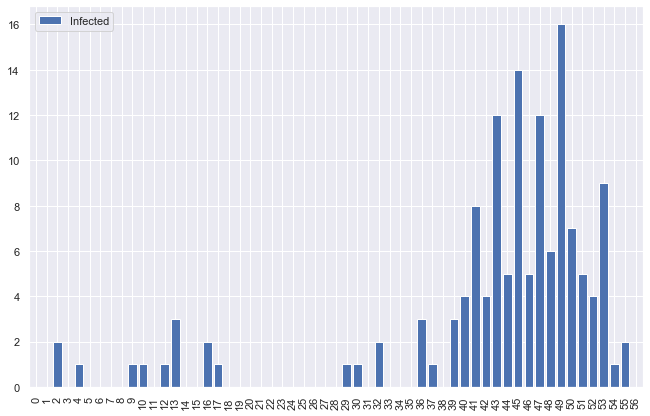

In [106]:
covid19_usa.plot.bar(width=0.8)

# Analysis on the number of positive cases

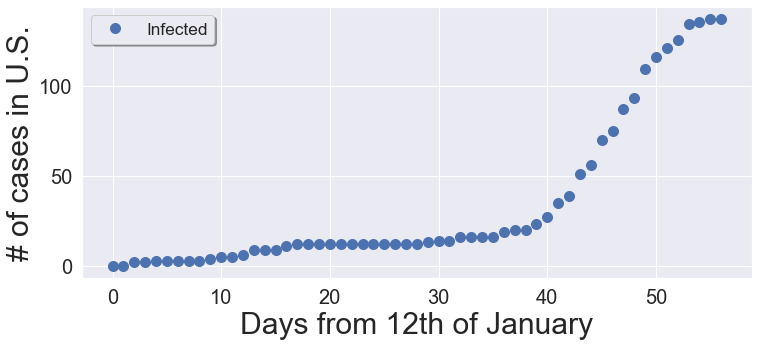

In [128]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tdata, total_infected_usa, 'o', label='Infected',markersize=10)
ax.tick_params(labelsize=20)
plt.xlabel('Days from 12th of January',fontsize=30)
plt.ylabel('# of cases in U.S.',fontsize=30)
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()

In [108]:
#Define the function to use for curve_fit. Here we are useing the Verhulst model, which is a logistic (sigmoid) function with 3 parameters
def Verhulst(t, K, I0, r):
    return (K*I0*np.exp(r*t))/(K+I0*(np.exp(r*t)-1))

def Exponential(t, tau, a):
    return a*np.exp(t/tau)

In [109]:
#Fit the data on the number of cases with an exponential curve and a Verhulst model
popt_exp, pcov_exp = curve_fit(Exponential, tdata, total_infected_usa,bounds=([0,0],[1000,1000]))
popt, pcov = curve_fit(Verhulst, tdata, total_infected_usa, bounds=([0,0,0],[60000000,1000,1]))

In [110]:
#Define an array of "Future data" to continue the plot and extract a prediction
future_tdata = np.linspace(tdata[-1],tdata[-1]+200,num=100)
new_tdata = np.append(tdata,future_tdata)

### Plot of the exponential and Verhulst fit, with data on the number of infected cases

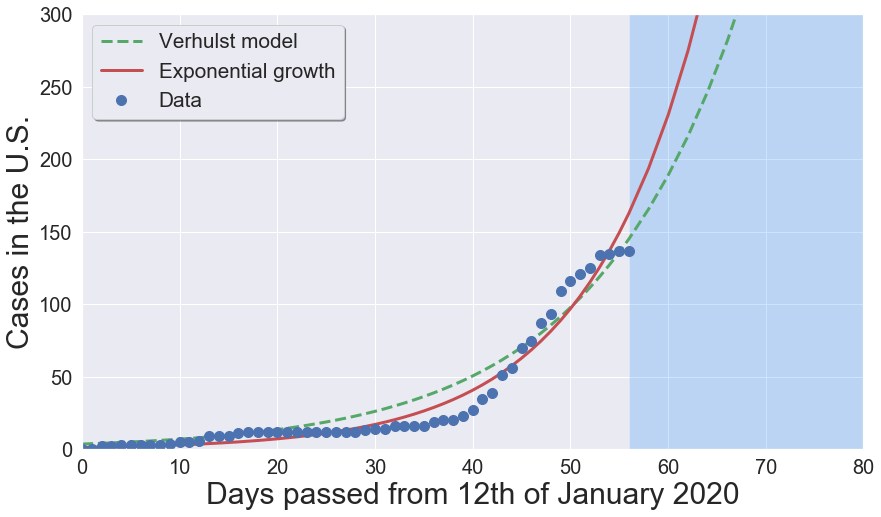

In [129]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(new_tdata, Verhulst(new_tdata, *popt), 'g--', label='Verhulst model',linewidth=3)
ax.plot(new_tdata,Exponential(new_tdata,*popt_exp),'r',label='Exponential growth',linewidth=3)
ax.plot(tdata, total_infected_usa, 'o', label='Data',markersize=10)
ax.tick_params(labelsize=20)
plt.ylabel('Cases in the U.S.',fontsize=30)
plt.xlabel('Days passed from 12th of January 2020',fontsize=30)
ax.set_ylim([0,300])
ax.set_xlim([0,80])
legend = ax.legend(loc='upper left', shadow=True, fontsize='xx-large')
plt.axvspan(tdata[-1],new_tdata[-1], facecolor='#0080FF', alpha=0.2)
#plt.xticks(tdata,covid19_daily['Data'],rotation=50)
#plt.savefig('./Plots/COVID-19_Cases_Italy.png')
plt.show()


### Parameters of the fit, with their error - Verhulst Model

In [130]:
#K = popt[0], P0 = popt[1], r = popt[2]
delta_r = np.sqrt(pcov[2,2])
delta_K = np.sqrt(pcov[0,0])
from prettytable import PrettyTable
t = PrettyTable(['Verhulst Parameters', 'Value','Error'])
t.add_row(['r', popt[2], delta_r])
t.add_row(['K', popt[0], delta_K])
print(t)

+---------------------+---------------------+------------------------+
| Verhulst Parameters |        Value        |         Error          |
+---------------------+---------------------+------------------------+
|          r          | 0.06584311162305305 | 0.0037505379431106863  |
|          K          |  42526951.176529095 | 1.6619132961562102e-13 |
+---------------------+---------------------+------------------------+


### 1-Sigma confidence intervals for the SIS Model parameters

\begin{align}
& r = \left( 0.066 \pm 0.004\right) \sim \left[ \, 0.062 \,,\, 0.07 \,\right]  && &&& K = 42526951
\end{align}

## Convert the Verhulst parameters (r,K) into the SIS Model parameters ($\beta$, $\gamma$)

In [131]:
beta = popt[2]/popt[0]
gamma = beta*N_US-popt[2]
R0 = N_US/(N_US-popt[2])
delta_beta = np.sqrt(np.power(delta_r/popt[0],2)+np.power(popt[2]/(np.power(popt[0],2)),2))
delta_gamma = np.sqrt(np.power((N_US/popt[0]-1)*delta_r,2)+np.power((popt[2]*N_US/(np.power(popt[0],2)))*delta_K,2))

In [132]:
from prettytable import PrettyTable
t = PrettyTable(['SIS Model Parameters', 'Value','Error'])
t.add_row(['beta', beta, delta_beta])
t.add_row(['gamma', gamma, delta_gamma])
print(t)

+----------------------+------------------------+-----------------------+
| SIS Model Parameters |         Value          |         Error         |
+----------------------+------------------------+-----------------------+
|         beta         | 1.5482678584161541e-09 | 8.819202504177992e-11 |
|        gamma         |   0.4407501316507126   |  0.025105892650557245 |
+----------------------+------------------------+-----------------------+


### 1-Sigma confidence intervals for the SIS Model parameters

\begin{align}
& \beta = \left( 1.54 \pm 0.09\right) \times 10^{-9} \sim \left[ \, 1.45 \,,\, 1.63\,\right]  \times 10^{-8} && &&& \gamma  = \left( 0.441 \pm 0.025\right) \sim \left[\, 0.416 \, , \, 0.466 \, \right]
\end{align}